In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.interpolation import shift

plt.rcParams.update({'font.size': 18})

# Part 1

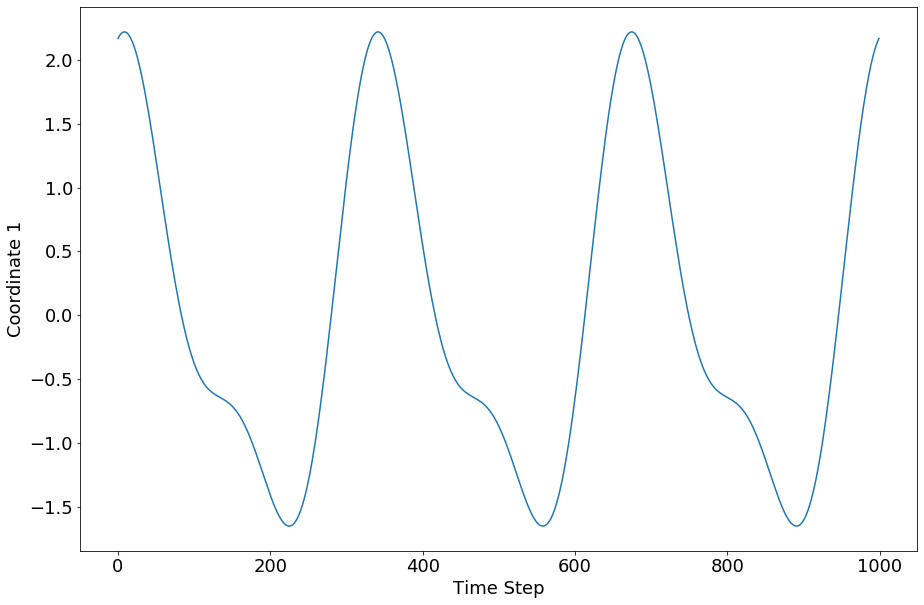

In [6]:
X = np.loadtxt('takens_1.txt', delimiter=' ')
x_0 = np.asarray(X[:,0])
plt.figure(figsize=(15,10))
plt.xlabel('Time Step')
plt.ylabel('Coordinate 1')
plt.plot(x_0)
plt.show()

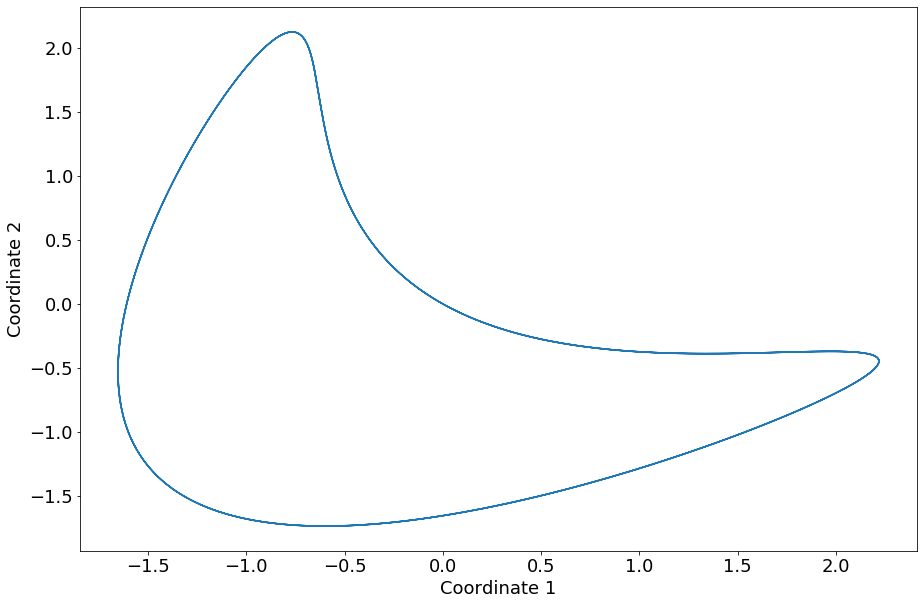

In [5]:
# We Plot the original shape of the data first

plt.figure(figsize=(15,10))
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.plot(X[:,0],X[:,1])
plt.show()

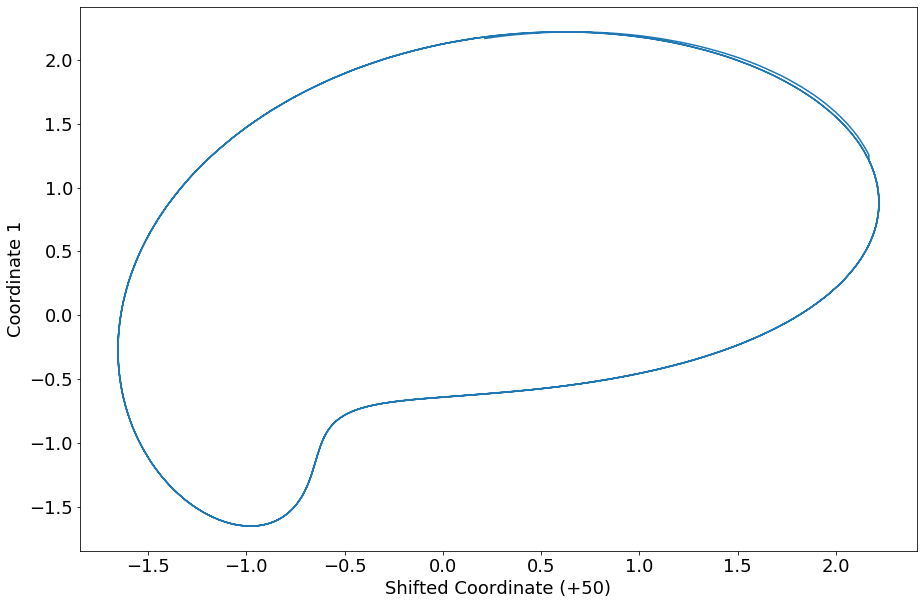

In [8]:
shift_del = 50

shifted_xs = (np.array([x_0,]*2)).transpose()
shifted_xs[:,1] = np.roll(shifted_xs[:,1],shift_del)

plt.figure(figsize=(15,10))
plt.xlabel('Shifted Coordinate (+50)')
plt.ylabel('Coordinate 1')
plt.plot(shifted_xs[:,1], shifted_xs[:,0],)

# Part 2

In [0]:
Axes3D

mpl_toolkits.mplot3d.axes3d.Axes3D

In [0]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

In [0]:
dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

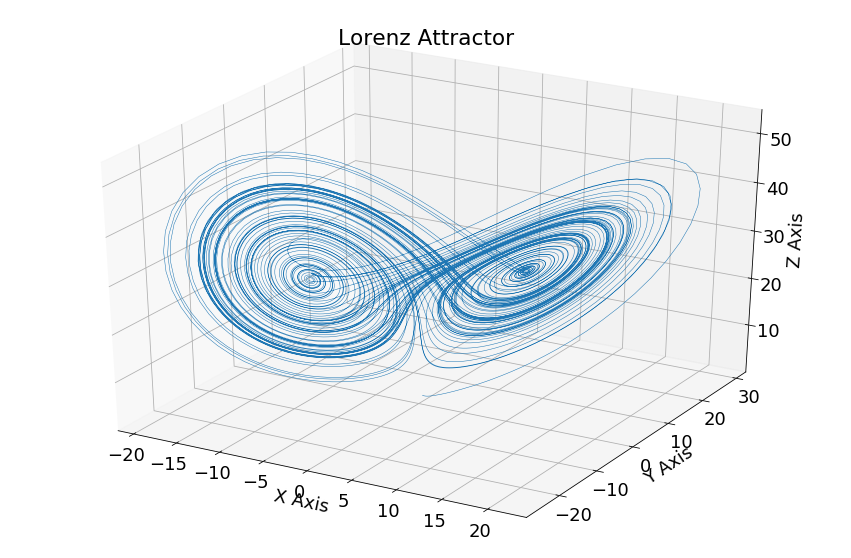

In [0]:
# Plot
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

#### Time-delay embedding on x-axis

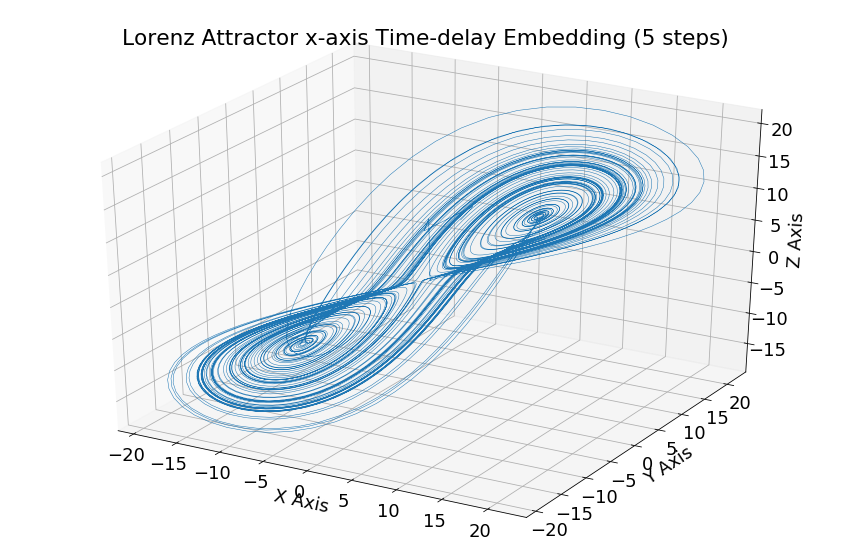

In [0]:
shift_del = 5
shifted_xs = (np.array([xs,]*3)).transpose()
shifted_xs[:,1] = np.roll(shifted_xs[:,1],shift_del)
shifted_xs[:,2] = np.roll(shifted_xs[:,2],2 * shift_del)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

ax.plot(shifted_xs[:,0], shifted_xs[:,1], shifted_xs[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor x-axis Time-delay Embedding (" + str(shift_del) + " steps)")

plt.show()

#### Time-delay embedding on z-axis

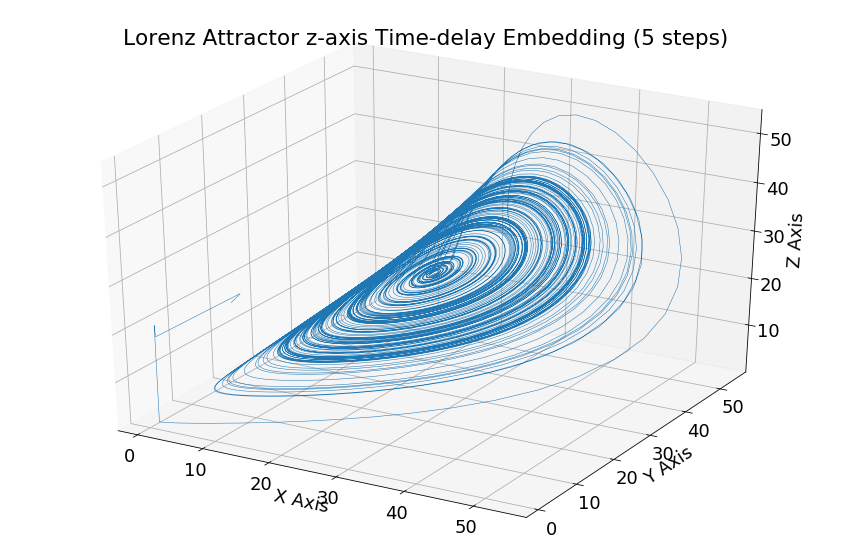

In [0]:
shift_del = 5
shifted_xs = (np.array([zs,]*3)).transpose()
shifted_xs[:,1] = np.roll(shifted_xs[:,1],shift_del)
shifted_xs[:,2] = np.roll(shifted_xs[:,2],2 * shift_del)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

ax.plot(shifted_xs[:,0], shifted_xs[:,1], shifted_xs[:,2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor z-axis Time-delay Embedding (" + str(shift_del) + " steps)")

plt.show()

# Part 3

In [0]:
def read_trajectories(file, n):
    traj = pd.read_csv(file, delimiter=' ')
    ped_traj = {}
    for i in range(1, n+1):
        ped_traj[i] = traj[traj['pedestrianId'] == i].reset_index()
    return ped_traj

def plot_trajectories(out_folder, alpha, n, ext="trajectories", id=1):
    traj = read_trajectories(out_folder + "\\postvis." + ext, n)
    # plot x, y vs t
    plt.figure(figsize=(15, 10))
    plt.plot(range(traj[1].shape[0]), traj[1]['x-PID1'])
    plt.plot(range(traj[1].shape[0]), traj[1]['y-PID1'])
    plt.legend(['x', 'y'], loc='upper left')
    plt.xlabel("Timestep n")
    plt.ylabel("Position")
    plt.title("x,y vs timesteps. Alpha " + str(round(alpha, 1)))
    # plot x vs x + diff
    diff = 45
    plt.figure(figsize=(10, 10))
    plt.plot(traj[id][:traj[id].shape[0] - diff]['x-PID1'], traj[id][diff:]['x-PID1'])
    plt.xlabel("x(n)")
    plt.ylabel("x(n+" + str(diff) + ")")
    plt.title("x(n+" + str(diff) + ") vs x(n). Alpha " + str(round(alpha, 1)))
    return traj

def pca_projection(df, n_components):
    '''
    Projects data onto first n principal components in increasing order
    of eigenvalues and prints energy preserved
    Input:
        df - pandas dataframe containing 2D data
        n_components - number of principal components to use
    Output:
        proj - projection of df onto first n_components PCs
        v - right singular vectors transposed
    '''
    # subtract mean from data
    df = df - df.mean(axis=0)
    # SVD decomposition (in decreasing order of eigenvalues)
    u, s, v = np.linalg.svd(df, full_matrices=False)
    # calculate energy preserved in first n_components
    energy = np.round(np.sum(s[:n_components]) / np.sum(s) * 100, 2)
    print("Energy: ", energy, "%")
    # set eigenvalues of unused components to 0
    s[n_components:] = 0
    # compute projection of data onto PCs
    proj = u @ np.diag(s)
    return proj, v

def pca_2d_reconstruction(df, n_components):
    '''
    Performs PCA reconstruction of 2D data
    Input:
        df - pandas dataframe containing 2D data
        n_components - number of principal components to use
    Output:
        proj @ v - reconstructed data
    '''
    # get projection of data onto PCs, eigenvectors and energies
    proj, v = pca_projection(df, n_components)
    # calculate and return reconstruction and energy
    return proj @ v

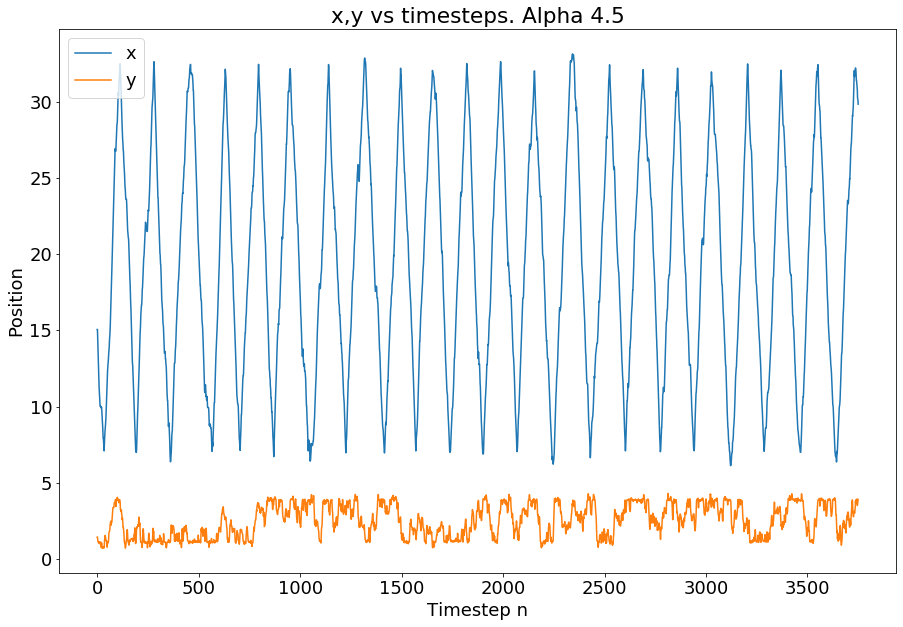

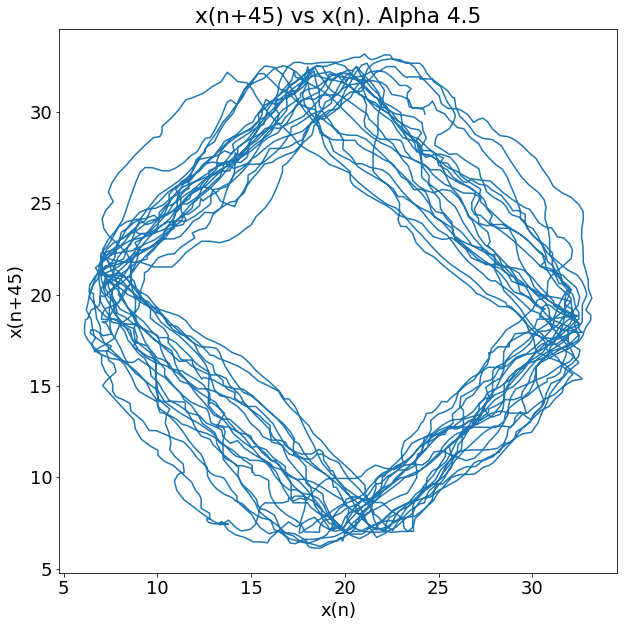

In [0]:
traj = plot_trajectories("..\\data", 4.5, 100)

Energy:  57.05 %


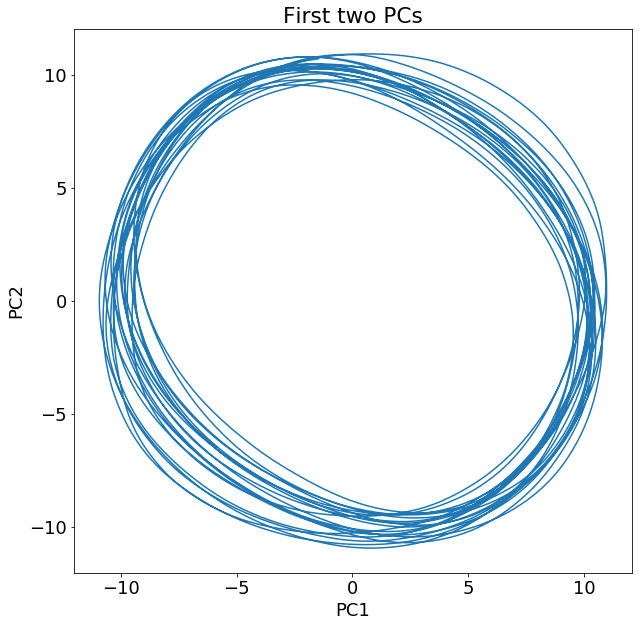

In [0]:
ped1 = traj[1]['x-PID1']
n = 200
big_dim = np.vstack([ped1[i:i+n] for i in range(0, ped1.shape[0] - n)])
rec = pca_2d_reconstruction(big_dim, 2)
diff = 45
plt.figure(figsize=(10, 10))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two PCs")
plt.plot(rec[:rec.shape[0] - diff, 0], rec[diff:, 1])